In [61]:
from google.colab import files
uploaded = files.upload()

Saving cookie_cats.csv to cookie_cats (1).csv


In [83]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import xgboost as xgb
import shap
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve

In [99]:
df = pd.read_csv("cookie_cats.csv")

# Encode necessary values
df['retention_1'] = df['retention_1'].astype(int)
df['retention_7'] = df['retention_7'].astype(int)
df['version_encoded'] = df['version'].map({'gate_30': 0, 'gate_40': 1})

In [100]:
# Split groups
group_30 = df[df['version'] == 'gate_30']
group_40 = df[df['version'] == 'gate_40']

# Day 1 t-test
t1, p1 = stats.ttest_ind(group_30['retention_1'], group_40['retention_1'])
print(f"Day 1 Retention — t-stat: {t1:.4f}, p-value: {p1:.4f}")

# Day 7 t-test
t7, p7 = stats.ttest_ind(group_30['retention_7'], group_40['retention_7'])
print(f"Day 7 Retention — t-stat: {t7:.4f}, p-value: {p7:.4f}")

Day 1 Retention — t-stat: 1.7841, p-value: 0.0744
Day 7 Retention — t-stat: 3.1645, p-value: 0.0016


In [101]:
# Features + label
X = df[['sum_gamerounds', 'version_encoded']]
y = df['retention_7']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)

# Predict probabilities on full dataset
df['model_pred'] = model.predict_proba(X)[:, 1]


In [102]:
# SHAP explanation on full dataset (X)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

# Add SHAP values
df['shap_gamerounds'] = shap_values[:, 0]
df['shap_version'] = shap_values[:, 1]

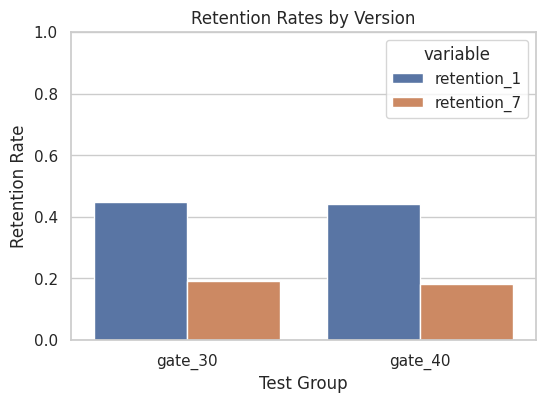

In [105]:
# Group-level retention rates
retention = df.groupby('version')[['retention_1', 'retention_7']].mean().reset_index()

# Plot
plt.figure(figsize=(6, 4))
sns.barplot(x='version', y='value', hue='variable',
            data=pd.melt(retention, id_vars='version'))
plt.title("Retention Rates by Version")
plt.ylabel("Retention Rate")
plt.xlabel("Test Group")
plt.ylim(0, 1)
plt.show()


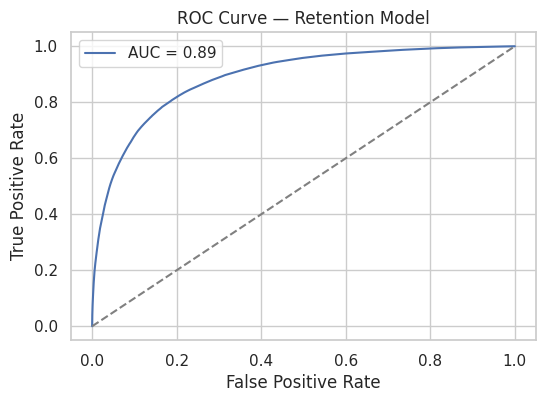

In [106]:
y_true = df['retention_7']
y_scores = df['model_pred']

fpr, tpr, thresholds = roc_curve(y_true, y_scores)
auc_score = roc_auc_score(y_true, y_scores)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}")
plt.plot([0, 1], [0, 1], '--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve — Retention Model")
plt.legend()
plt.grid(True)
plt.show()

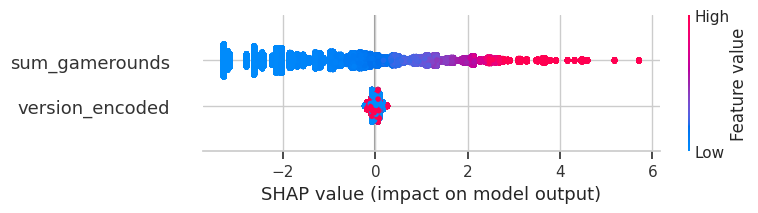

In [107]:
# Global SHAP importance plot (summary of all users)
shap.summary_plot(shap_values, X)

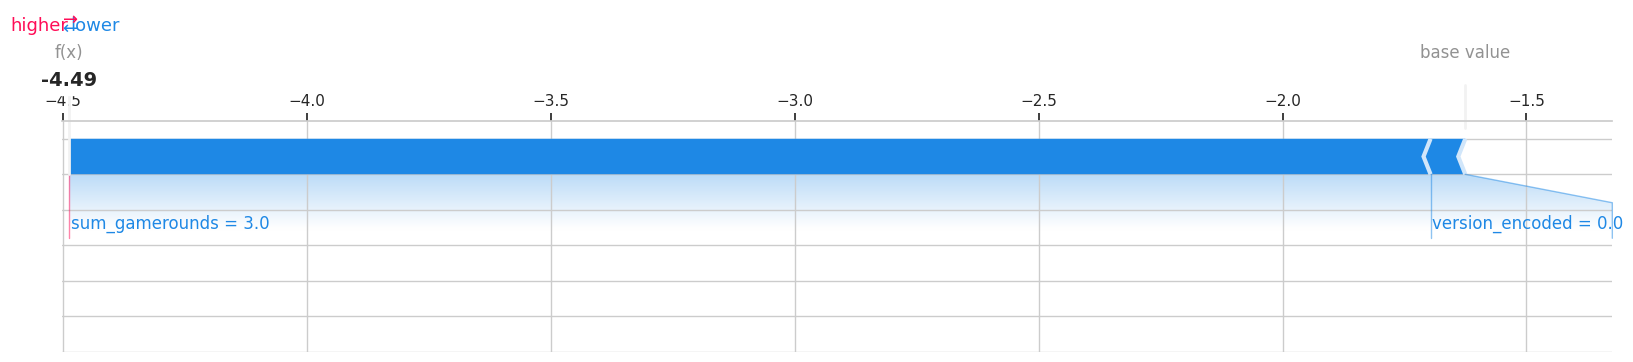

In [108]:
# Pick one test row for explanation
shap.initjs()
shap.force_plot(
    explainer.expected_value,
    shap_values[0, :],
    X.iloc[0],
    matplotlib=True  # this works well in Colab
)

In [109]:
print("User Features:")
print(X.iloc[0])  # or any index

print("\nPredicted Probability of Retention:")
print(model.predict_proba(X.iloc[[0]])[:, 1])

User Features:
sum_gamerounds     3
version_encoded    0
Name: 0, dtype: int64

Predicted Probability of Retention:
[0.0111235]
